In [1]:

from datetime import datetime
import time
import os
from tqdm import tqdm
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import jieba.posseg as jp,jieba
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib

D:\ML_ENVS\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\ML_ENVS\lib\site-packages\gensim\corpora\dictionary.py:11: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
D:\ML_ENVS\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [3]:
def extract_info(x):

    CreationDate = re.findall(r'CreationDate = (.*?)//',x)[0]

    Title = re.findall(r'Title = (.*?)//',x)[0]

    Tags = re.findall(r'Tags = (.*?)//',x)[0]
    Tags = Tags.split('><')
    Tags[0] = Tags[0].lstrip('<')
    Tags[-1] = Tags[-1].rstrip('>')
    Tags = ' '.join(Tags)

    Score = re.findall(r'Score = (.*?)//',x)[0]


    AnswerCount = re.findall(r'AnswerCount = (.*?)//',x)
    if AnswerCount==[] or AnswerCount==['']:
        AnswerCount = re.findall(r'AnswerCount = (.*?)\n',x)
        if AnswerCount == [] or AnswerCount==['']:
            AnswerCount = None
        else:
            AnswerCount = AnswerCount[0]
    else:
        AnswerCount = AnswerCount[0]


    CommentCount = re.findall(r'CommentCount = (.*?)//',x)
    if CommentCount==[] or CommentCount==['']:
        CommentCount = re.findall(r'CommentCount = (.*?)\n',x)
        if CommentCount==[] or CommentCount==['']:
            CommentCount = None
        else:
            CommentCount = CommentCount[0]
    else:
        CommentCount = CommentCount[0]

    FavoriteCount = re.findall(r'FavoriteCount = (.*?)//',x)
    if FavoriteCount==[] or FavoriteCount==['']:
        FavoriteCount = re.findall(r'FavoriteCount = (.*?)\n',x)
        if FavoriteCount==[] or FavoriteCount==['']:
            FavoriteCount = None
        else:
            FavoriteCount = FavoriteCount[0]
    else:
        FavoriteCount = FavoriteCount[0]



    return CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount

In [7]:
new_df = pd.DataFrame({'CreationDate':[],'Title':[], 'Tags':[],
                          'Score':[],'AnswerCount':[], 'CommentCount':[],
                          'FavoriteCount':[]})

CreationDate_list = []
Title_list = []
Tags_list = []
Score_list = []
AnswerCount_list = []
CommentCount_list = []
FavoriteCount_list = []


with open('./D-CCFinder-NewData-javamelody-10-14717.java.txt', 'r', encoding='utf-8') as f:
    lines = f.readlines()
    # lines = list(set(lines))
    for l in lines:
        CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount = extract_info(l)
        CreationDate_list.append(CreationDate)
        Title_list.append(Title)
        Tags_list.append(Tags)
        Score_list.append(Score)
        AnswerCount_list.append(AnswerCount)
        CommentCount_list.append(CommentCount)
        FavoriteCount_list.append(FavoriteCount)
            # new_df.loc[len(new_df)] = [CreationDate, Title, Tags, Score, AnswerCount, CommentCount, FavoriteCount]


new_df['CreationDate'] = CreationDate_list
new_df['Title'] = Title_list
new_df['Tags'] = Tags_list
new_df['Score'] = Score_list
new_df['AnswerCount'] = AnswerCount_list
new_df['CommentCount'] = CommentCount_list
new_df['FavoriteCount'] =FavoriteCount_list

# new_df = new_df.drop_duplicates()
df1 = new_df
df1.info()
df1.head(2)

df1['Tags'] = df1['Tags'].apply(lambda x: x.replace('java', ''))
df1.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CreationDate   253 non-null    object
 1   Title          253 non-null    object
 2   Tags           253 non-null    object
 3   Score          253 non-null    object
 4   AnswerCount    253 non-null    object
 5   CommentCount   253 non-null    object
 6   FavoriteCount  9 non-null      object
dtypes: object(7)
memory usage: 14.0+ KB


,CreationDate,Title,Tags,Score,AnswerCount,CommentCount,FavoriteCount
0,2014-06-13T00:41:24.500,What is the default implementation of .stream(...,-8,-4,1,18,None
1,2013-03-11T04:12:18.823,for loop understanding,,-3,7,3,None


In [8]:
text = df1['Title'] + pd.Series([' ']*len(df1)) + df1['Tags']
text = text.to_list()
print(len(text))
text[:5]


253


['What is the default implementation of .stream() in java 8?  -8',
 'for loop understanding ',
 'How to reduce the time for sending data to remote server?  android http',
 'HashSet contains duplicate entries  set unique hashset',
 "Folder created on Android external storage isn't visible via MTP but showing in adb shell  android cordova"]

In [9]:
def separate_sentence(text):
    text = text.lower()
    remove_chars = '[·’!"\#$%&\'()＃！（）*+,-./:;<=>?\@，：?￥★、…．＞【】［］《》？“”‘’\[\\]^_`{|}~]+'
    text = re.sub(remove_chars, "", text)

    disease_List = nltk.word_tokenize(text)

    filtered = [w for w in disease_List if(w not in stopwords.words('english'))]

    Rfiltered =nltk.pos_tag(filtered)

    filter_word = [i[0] for i in Rfiltered]
    return filter_word


In [10]:
text = [separate_sentence(i) for i in tqdm(text)]
print(len(text))

100%|██████████| 253/253 [00:00<00:00, 300.55it/s]


253


In [11]:

dictionary = Dictionary(text)

corpus = [dictionary.doc2bow(words) for words in text]

def perplexity(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=15))
    print(ldamodel.log_perplexity(corpus))
    return ldamodel.log_perplexity(corpus)

def coherence(num_topics):
    ldamodel = LdaModel(corpus, num_topics=num_topics, id2word = dictionary, passes=30,random_state = 1)
    print(ldamodel.print_topics(num_topics=num_topics, num_words=10))
    ldacm = CoherenceModel(model=ldamodel, texts=text, dictionary=dictionary, coherence='c_v')
    print(ldacm.get_coherence())
    return ldacm.get_coherence()




In [13]:
x = range(1,30)
# z = [perplexity(i) for i in x]
y = [coherence(i) for i in x]

[(0, '0.068*"whileloop" + 0.068*"fx" + 0.068*"crash" + 0.068*"causes" + 0.068*"window" + 0.068*"javafx" + 0.025*"android" + 0.021*"random" + 0.021*"drawing" + 0.021*"gloutofmemory"')]
0.3014084403834645
[(0, '0.099*"window" + 0.099*"whileloop" + 0.099*"fx" + 0.099*"causes" + 0.099*"javafx" + 0.099*"crash" + 0.032*"android" + 0.031*"gloutofmemory" + 0.031*"opengles20" + 0.031*"opengles"'), (1, '0.061*"redis" + 0.040*"spring" + 0.037*"correctly" + 0.033*"returning" + 0.033*"data" + 0.031*"prefixes" + 0.031*"hash" + 0.031*"weird" + 0.031*"springdataredis" + 0.031*"results"')]
0.37254347003287686
[(0, '0.106*"window" + 0.106*"whileloop" + 0.106*"fx" + 0.106*"causes" + 0.106*"javafx" + 0.106*"crash" + 0.033*"android" + 0.033*"gloutofmemory" + 0.033*"opengles" + 0.033*"opengles20"'), (1, '0.026*"android" + 0.025*"apache" + 0.021*"java" + 0.018*"maven" + 0.017*"component" + 0.017*"awss3" + 0.017*"camel" + 0.017*"bucket" + 0.017*"apachecamel" + 0.017*"passing"'), (2, '0.080*"redis" + 0.052*"sp

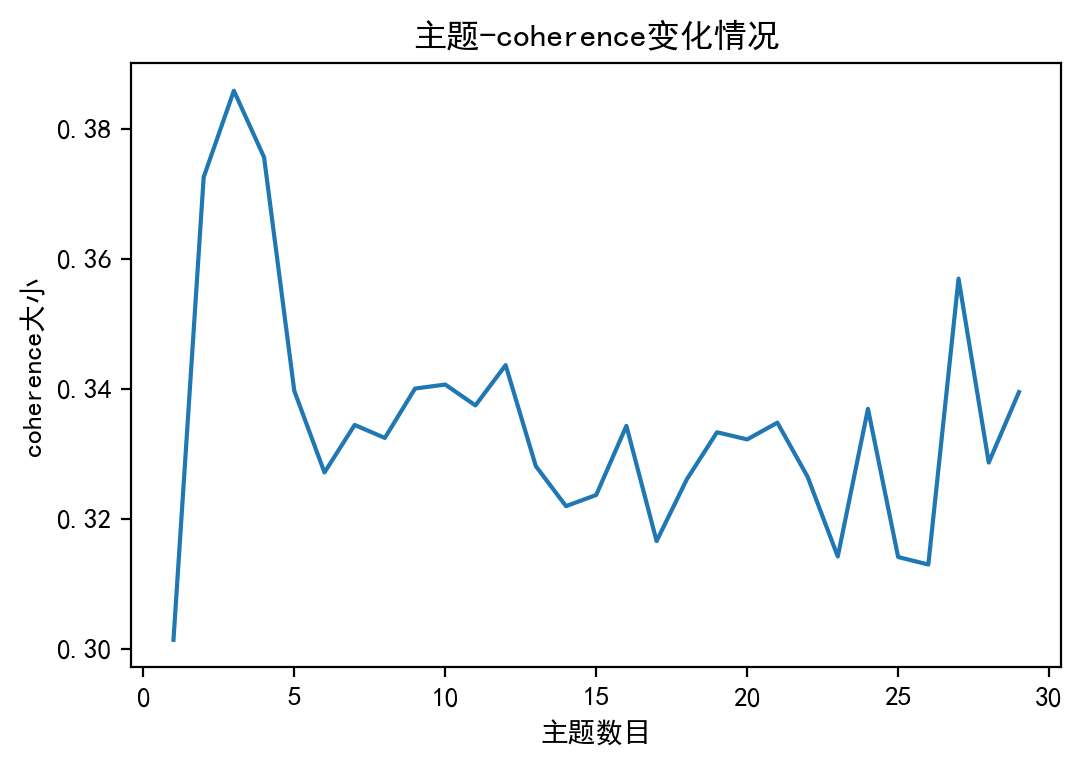

In [19]:
plt.figure(dpi=200)
plt.plot(x, y)
plt.xlabel('topic nums')
plt.ylabel('coherence')
plt.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['axes.unicode_minus']=False
plt.title('topic-coherence')
# plt.show()
plt.savefig('./pic/topic-coherence.jpg')

In [15]:

dictionary = Dictionary(text)

corpus = [dictionary.doc2bow(words) for words in text]

lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state=100, iterations=50)

ldaCM = CoherenceModel(model=lda, corpus=corpus, dictionary=dictionary, coherence='u_mass')


for topic in lda.print_topics(num_words=10):
    print(topic)


(0, '0.051*"redis" + 0.044*"gloutofmemory" + 0.043*"android" + 0.042*"random" + 0.041*"opengles" + 0.040*"error" + 0.038*"outofmemory" + 0.038*"drawing" + 0.038*"getting" + 0.035*"opengles20"')
(1, '0.059*"opengles20" + 0.051*"getting" + 0.051*"drawing" + 0.049*"outofmemory" + 0.048*"android" + 0.044*"error" + 0.042*"opengles" + 0.039*"random" + 0.035*"gloutofmemory" + 0.017*"xml"')
(2, '0.135*"javafx" + 0.135*"causes" + 0.135*"whileloop" + 0.135*"crash" + 0.135*"fx" + 0.134*"window" + 0.006*"android" + 0.004*"apache" + 0.004*"maven" + 0.004*"properties"')


In [16]:

plot =pyLDAvis.gensim_models.prepare(lda,corpus,dictionary, sort_topics=False)

pyLDAvis.save_html(plot, './pic/high_sim.html')

